In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
import math
import torch
import torchvision
import gpytorch
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
import lbg_forecast.cosmology as cos

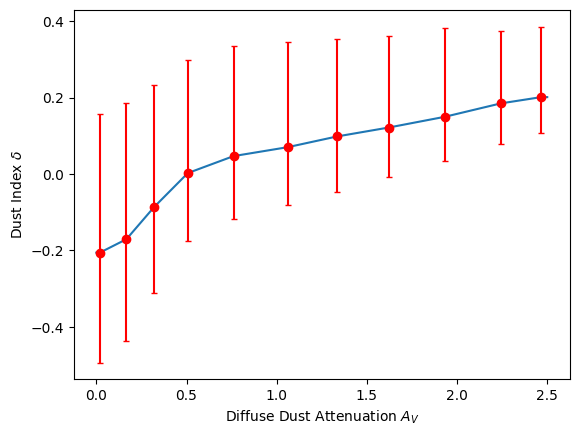

In [2]:
def extract_from_file(file):
    #https://iopscience.iop.org/article/10.3847/1538-4357/aabf3c
    #and popcosmos

    data = ascii.read(file)
    av = np.array(data['x'])
    n = np.array(data['y'])
    n_err_l_val = np.array(data['yl'])
    n_err_h_val = np.array(data['yh'])
    n_err_l = n - n_err_l_val
    n_err_h = n_err_h_val - n
    n_err = n_err_l + n_err_h

    return n, av, n_err, n_err_l, n_err_h

d_pop, av_pop, d_err_pop, d_err_l_pop, d_err_h_pop = extract_from_file("dust_data/popcosmos_data.txt")
plt.errorbar(av_pop, d_pop, yerr=[d_err_l_pop, d_err_h_pop], fmt='ro', capsize=2)
plt.ylabel("Dust Index $\delta$")
plt.xlabel("Diffuse Dust Attenuation $A_{V}$")



train_d = torch.from_numpy(d_pop)
train_av = torch.from_numpy(av_pop)
d_errors = torch.from_numpy(d_err_pop)


mean = np.interp(np.linspace(0, 2.5, 100), train_av, train_d)
plt.plot(np.linspace(0, 2.5, 100), mean)

In [3]:
class CSFRDModel(gpytorch.models.ExactGP):

    def __init__(self, train_x, train_y, likelihood):
        super(CSFRDModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(lengthscale_constraint=gpytorch.constraints.GreaterThan(1.0)))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(torch.square(d_errors), learn_additional_noise=False, noise_constraint=gpytorch.constraints.GreaterThan(0.0))
#likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(0.0))
model = CSFRDModel(train_av, torch.zeros_like(train_av), likelihood)
#model.likelihood.noise = train_scaled_csfrd_errors*1e-9

for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

Parameter name: covar_module.raw_outputscale               value = 0.0
Parameter name: covar_module.base_kernel.raw_lengthscale   value = 0.0


In [4]:
training_iter = 10000


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_av)
    # Calc loss and backprop gradients
    loss = -mll(output, torch.zeros_like(train_av))
    loss.backward()
    #print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        #i + 1, training_iter, loss.item(),
    print(loss.item())
        #model.likelihood.noise.item()
    #))
    optimizer.step()

0.3530694630799564
0.3530174547670871
0.3529654389681563
0.3529134462875305
0.3528614446435713
0.35280945007370956
0.35275746408081865
0.3527054851671075
0.3526535060714038
0.35260152527950644
0.3525495530875016
0.3524975791963527
0.3524456066707817
0.35239365571911835
0.35234169736201026
0.3522897460883325
0.35223780189542797
0.35218585911346134
0.3521339290825111
0.3520819916773866
0.35203007015369414
0.35197814691366697
0.3519262251258699
0.35187431764049487
0.3518224012235136
0.3517705006974662
0.3517186072550892
0.351666713695633
0.35161482722088183
0.35156294782818254
0.35151106832629214
0.3514592047282525
0.3514073250273784
0.35135547559994645
0.35130361007298716
0.35125176763279226
0.3511999251031939
0.3511480824910253
0.3510962541296962
0.35104442568681693
0.3509926043261892
0.3509407828913437
0.35088896853976587
0.3508371701139044
0.35078535563422797
0.3507335713740702
0.3506817799145414
0.3506299866884918
0.3505782093977005
0.35052643918832954
0.3504746689322641
0.3504229057

In [5]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

test_x = torch.linspace(0, 2.5, 100)

f_preds = model(test_x)
#y_preds = likelihood(model(test_x))

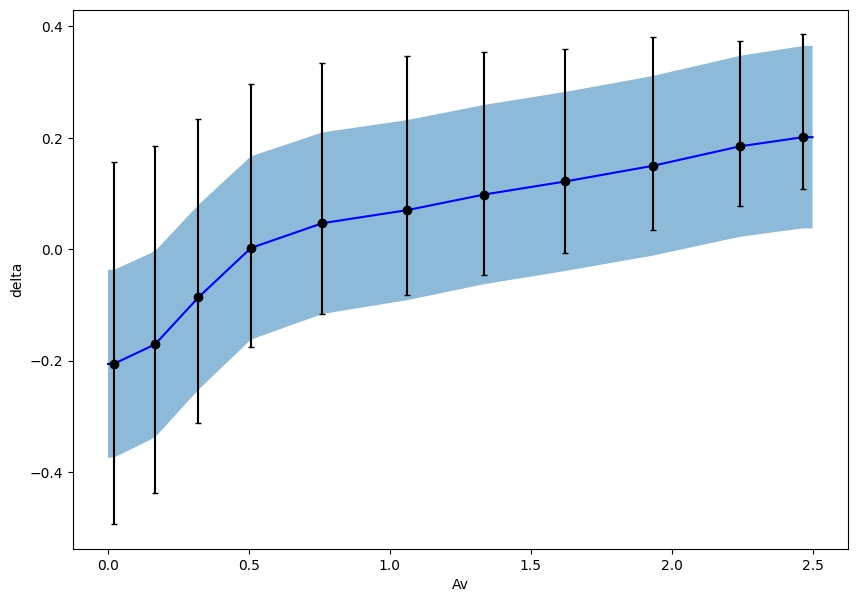

In [6]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(10, 7))

    # Get upper and lower confidence bounds
    lower, upper = f_preds.confidence_region()
    # Plot training data as black stars
    ax.errorbar(train_av.numpy(), train_d.numpy(), yerr=[d_err_l_pop, d_err_h_pop], fmt='ko', capsize=2)
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), f_preds.mean + mean, 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower+mean, upper+mean, alpha=0.5)
    #ax.legend(['Observed Data', 'Mean', 'Confidence'])

    ax.set_xlabel("Av")
    ax.set_ylabel("delta")

In [7]:
for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

Parameter name: covar_module.raw_outputscale               value = -4.4727373123168945
Parameter name: covar_module.base_kernel.raw_lengthscale   value = 2.8376524448394775


/Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


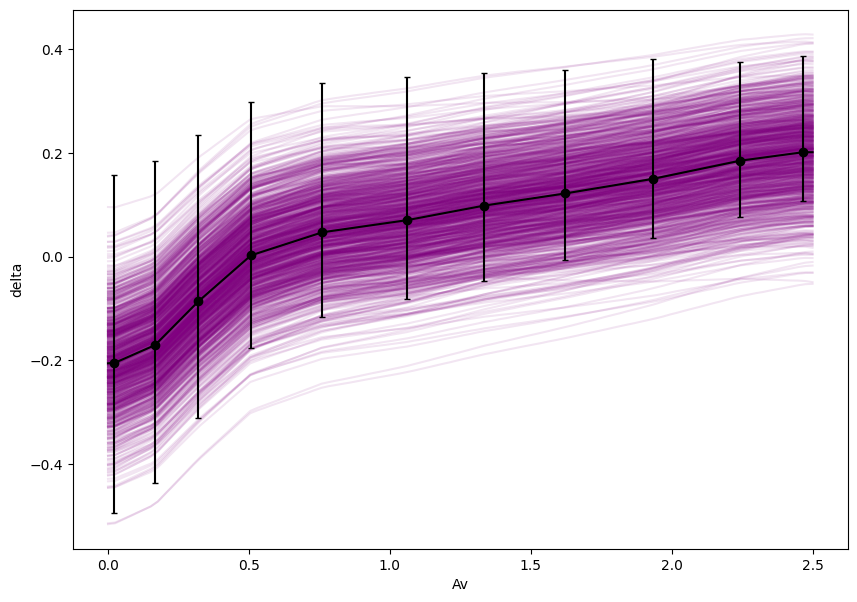

In [8]:
with torch.no_grad():

    f, ax = plt.subplots(1, 1, figsize=(10, 7))

    nsamples = 1000
    for sample in range(nsamples):
        f_sample = f_preds.sample()
        #if((f_sample > 0.0).all()):
        ax.plot(test_x, f_sample+mean, c='purple', alpha=0.1)
    ax.plot(test_x, f_preds.mean+mean, zorder=1000, ls='-', c='k')
    ax.errorbar(train_av.numpy(), train_d.numpy(), yerr=[d_err_l_pop, d_err_h_pop], fmt='ko', capsize=2)
    
    ax.set_xlabel("Av")
    ax.set_ylabel("delta")

In [9]:
#torch.save(model.state_dict(), 'gp_models/gp_index.pth')